# Scripts for basic data collection

1. bug reports
2. bug fixes
3. triggering tests

## Setup

This is probably the only part of the script that <span style="color:red">must be updated</span> according to individual environment.

In [2]:
import os

doc = "/Users/IceCream/Documents"
proj_repo_str = "defects4j/framework/projects"
proj_repo_path = os.path.join(doc, proj_repo_str)

# this script related input/output directories
code_repo = os.path.join(doc, 'icse23_bias', 'scripts')
out_repo = os.path.join(doc, 'icse23_bias', 'data')
if not os.path.exists(out_repo):
    os.mkdir(out_repo)
    
# active D4J working repositories
active_repo = os.path.join(doc, 'defects4j_projects')

# Chart has been removed
projs = ["Cli", "Closure", "Codec", "Collections", "Compress", "Csv", "Gson", "JacksonCore", "JacksonDatabind", "JacksonXml", "Jsoup", "JxPath", "Lang", "Math", "Mockito", "Time"]

##### `proj_path`: dictionary {proj: p_path}

In [3]:
import os

proj_path = {p: os.path.join(proj_repo_path, p) for p in projs}
print("Directories for all projects are available: {}".format(all(os.path.exists(path) for p, path in proj_path.items())))

Directories for all projects are available: True


## Data Collection

### Bug reports creation date

`Gson` github may be problematic because of GoogleCodeExporter, maybe manual extract would be better. <span style="color:red"> One or two Gson bug reports may need manual inspection, the issue report time is wrong (e.g., on https://github.com/google/gson/issues/40) because it is imported by GoogleCodeExporter.</span>

###### Beautiful Soup solution

By default, Defects4j generates the results in the UTC timezone(i.e., +0000). Similarity, the timezone retrieved from git issues uses the UTC timezone.

Manual verification of the code: \
`page = requests.get('https://github.com/mockito/mockito/issues/188')`
https://savvytime.com/converter/utc-to-pst/apr-1-2015/5pm \
`2015-04-01T00:16:10Z` to `2015-03-31 17:16:10-07:00`


in case of conversion, example: UTC to PST (America/Los_Angeles)\
`dt_tz = dt_tz.astimezone(timezone('America/Los_Angeles'))`

In [92]:
import os
import csv

# bug_mining.csv has been manually created for keeping track of the issue tracker information
tracker_info_file = os.path.join(out_repo, 'bug_repository.csv')
tracker_dict = {}
with open(tracker_info_file, "r") as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)
    for k, v, url in csvreader:
        tracker_dict[k] = v.strip()
print(tracker_dict)

{'Codec': 'jira', 'Cli': 'jira', 'Closure': 'google', 'Collections': 'jira', 'Compress': 'jira', 'Csv': 'jira', 'Gson': 'github', 'JacksonCore': 'github', 'JacksonDatabind': 'github', 'JacksonXml': 'github', 'Jsoup': 'github', 'JxPath': 'jira', 'Lang': 'jira', 'Math': 'jira', 'Mockito': 'github', 'Time': 'github'}


In [108]:
import re
import json
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime
from pytz import timezone

# google timestamps
def google_ts(proj, bugid, url):
    print(proj, bugid, url)
    
    # sample url: 'https://storage.googleapis.com/google-code-archive/v2/code.google.com/closure-compiler/issues/issue-253.json'
    page = requests.get(url)
    # create a BeautifulSoup object
    soup = BeautifulSoup(page.text, 'html.parser')
    
    # skip this if it is coming from sourceforge
    if 'sourceforge' in url:
        return [None, None]
    
    # loads json
    data = json.loads(soup.text)
    
    # save bug report details
    file = os.path.join(bug_mining_dir, '_'.join([proj, str(bugid)])+'.json')
    if not os.path.exists(file):
        with open(file, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)
       
    
    # creation time
    ct_dt = datetime.fromtimestamp(data['comments'][0]['timestamp'])
    # resolution time
    rt_dt = datetime.fromtimestamp(data['comments'][-1]['timestamp'])
    
    # debug
    print([ct_dt, rt_dt])
    return [ct_dt, rt_dt]



def git_ct_dt(soup): 
    # pull the creation time (relative-time class)
    time = soup.find('relative-time')
    # literal "Z" is part of the ISO 8601 datetime standard for UTC times
    return datetime.strptime(time['datetime'], '%Y-%m-%dT%H:%M:%SZ')

def git_rt_dt(soup):
    # find 'closed this' thread, extract resolution time
    for element in soup(text=re.compile(r'closed this')):
        close_tag_parent = element.parent
        time = close_tag_parent.find('relative-time')
        return datetime.strptime(time['datetime'], '%Y-%m-%dT%H:%M:%SZ')
        
    return None

def git_description(soup):
    # pull description and comments altogether
    description = ""
    for element in soup.findAll('td', {"class": "d-block comment-body markdown-body js-comment-body"}):
        description_tag = element.parent
        if description_tag.text:
            description = description + description_tag.text
    return description

def git_ts(proj, bugid, url):
    
    print(proj, bugid, url)
    
    # skip this if it is coming from sourceforge
    if 'sourceforge' in url:
        return [None, None]
    
    # sample url: 'https://github.com/mockito/mockito/issues/188'
    page = requests.get(url)
    # create a BeautifulSoup object
    soup = BeautifulSoup(page.text, 'html.parser')
    
    # invalid bugid
    if soup.title == None:
        return [None, None]
    
    # creation time
    ct_dt = git_ct_dt(soup)
    # resolution time
    rt_dt = git_rt_dt(soup)
    
    # description
    description = git_description(soup)
    # it seems that comments are not visible through soup
    # save description
    file = os.path.join(bug_mining_dir, '_'.join([proj, str(bugid)])+'.txt')
    save_txt(file, description)
    
    # debug
    print([ct_dt, rt_dt])
    return [ct_dt, rt_dt]



def jira_ct_dt(soup):
    # pull the creation time
    creation_time = soup.find("span", {"data-name" : "Created"})
    return datetime.strptime(creation_time.find("time")['datetime'], '%Y-%m-%dT%H:%M:%S+0000')
    
def jira_rt_dt(soup):
    # pull the resolution time
    resolution_time = soup.find("span", {"id": "resolutiondate-val"})    
    # +0000 for UTC times
    #dt_tz = pytz.utc.localize(dt)
    if resolution_time:
        return datetime.strptime(resolution_time.find("time")['datetime'], '%Y-%m-%dT%H:%M:%S+0000')
    return None

def jira_description(soup):
    # pull the description
    description = soup.find("div", {"id": "description-val"})
    return description.text if description else None

def save_txt(file, txt):
    with open(file, 'w+') as f:
        f.write(txt) if txt else f.write("")

def jira_ts(proj, bugid, url):
    
    print(proj, bugid, url)
    
    page = requests.get(url)
    # create a BeautifulSoup object
    soup = BeautifulSoup(page.text, 'html.parser')
    # creation time
    ct_dt = jira_ct_dt(soup)
    # resolution time
    rt_dt = jira_rt_dt(soup)
    
    # description
    description = jira_description(soup)
    # it seems that comments are not visible through soup
    # save description
    file = os.path.join(bug_mining_dir, '_'.join([proj, str(bugid)])+'.txt')
    save_txt(file, description)
    
    print([ct_dt, rt_dt])
    return [ct_dt, rt_dt]


def save_to_file(list_identifiers):
    out_file = os.path.join(out_dir, '_'.join(list_identifiers))
    out_file.to_csv()

def setup_out_folder(out_repo):
    out_dir = os.path.join(out_repo, 'bug_mining')
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    return out_dir

def setup_report_csv(csv_file, out_repo):
    col = ['project','id','report_creation','report_resolution']
    if os.path.exists(csv_file):
        return pd.read_csv(csv_file, names=col, skiprows=1)
    return pd.DataFrame(columns=col)

csv_file = os.path.join(out_repo, 'report.csv')
df = setup_report_csv(csv_file, out_repo)
bug_mining_dir = setup_out_folder(out_repo)

display(df)

for proj, path in proj_path.items():
    
    print(proj)
    bug_file = os.path.join(path, 'active-bugs.csv')
    df_bug = pd.read_csv(bug_file)
    
    # look up for the appropriate issue_tracker
    issue_tracker = tracker_dict[proj]
    
    if issue_tracker == 'jira':
        # if already in df, do nothing
        dt = [[proj, row['bug.id']]+jira_ts(proj, row['bug.id'], row['report.url']) for index, row in df_bug.iterrows() if not ((df['project'] == proj) & (df['id'] == row['bug.id'])).any()]
    elif issue_tracker == 'github':
        dt = [[proj, row['bug.id']]+git_ts(proj, row['bug.id'], row['report.url']) for index, row in df_bug.iterrows() if not ((df['project'] == proj) & (df['id'] == row['bug.id'])).any()]
    elif issue_tracker == 'google':
        dt = [[proj, row['bug.id']]+google_ts(proj, row['bug.id'], row['report.url']) for index, row in df_bug.iterrows() if not ((df['project'] == proj) & (df['id'] == row['bug.id'])).any()]
    else:
        print('undefined issue tracker?', issue_tracker)
    
    df_dt = pd.DataFrame(dt, columns=['project', 'id', 'report_creation', 'report_resolution'])
    df = pd.concat([df, df_dt])
    

df.reset_index()
df.to_csv(csv_file, index=False)


,project,id,report_creation,report_resolution
0,Cli,1,2005-10-11 02:06:11,2007-05-22 17:48:43
1,Cli,2,2005-05-10 10:50:14,2007-05-22 17:47:28
2,Cli,3,2002-10-24 22:32:22,2007-03-15 16:49:08
3,Cli,4,2002-10-24 22:32:22,2007-03-15 16:49:08
4,Cli,5,2007-06-05 23:51:39,2007-06-06 07:11:00
...,...,...,...,...
612,Time,23,NaN,NaN
613,Time,24,NaN,NaN
614,Time,25,NaN,NaN
615,Time,26,NaN,NaN


Cli
Closure
Closure 1 https://storage.googleapis.com/google-code-archive/v2/code.google.com/closure-compiler/issues/issue-253.json
[datetime.datetime(2010, 9, 26, 20, 51, 54), datetime.datetime(2013, 1, 7, 16, 58, 50)]
Closure 2 https://storage.googleapis.com/google-code-archive/v2/code.google.com/closure-compiler/issues/issue-884.json
[datetime.datetime(2012, 12, 21, 10, 3, 57), datetime.datetime(2012, 12, 26, 13, 29, 27)]
Closure 3 https://storage.googleapis.com/google-code-archive/v2/code.google.com/closure-compiler/issues/issue-864.json
[datetime.datetime(2012, 11, 19, 20, 3, 51), datetime.datetime(2012, 12, 20, 18, 23, 27)]
Closure 4 https://storage.googleapis.com/google-code-archive/v2/code.google.com/closure-compiler/issues/issue-873.json
[datetime.datetime(2012, 12, 12, 22, 9, 35), datetime.datetime(2012, 12, 17, 17, 30, 25)]
Closure 5 https://storage.googleapis.com/google-code-archive/v2/code.google.com/closure-compiler/issues/issue-851.json
[datetime.datetime(2012, 11, 2, 18,

###### We concatenate the report.csv (which contains the resolution and creation time) with bug details from each project.

In [109]:
csv_file = os.path.join(out_repo, 'report.csv')
df = setup_report_csv(csv_file, out_repo)
display(df)

df_bug_concat = pd.DataFrame()
for proj, path in proj_path.items():
    bug_file = os.path.join(path, 'active-bugs.csv')
    df_bug = pd.read_csv(bug_file)
    df_bug['project'] = proj
    df_bug.rename(columns={
        "bug.id": "id", 
        "revision.id.buggy": "revision_id_buggy", 
        "revision.id.fixed": "revision_id_fixed",
        "report.id": "report_id",
        "report.url": "report_url"
    }, inplace=True)
    df_bug['id'] = df_bug['id'].astype(int)
    df_bug_concat = pd.concat([df_bug_concat, df_bug])

df = pd.merge(df, df_bug_concat, on=["id", 'project'], how="left")
df.to_csv(os.path.join(out_repo, 'bug_mining.csv'), index=1)
    

,project,id,report_creation,report_resolution
0,Cli,1,2005-10-11 02:06:11,2007-05-22 17:48:43
1,Cli,2,2005-05-10 10:50:14,2007-05-22 17:47:28
2,Cli,3,2002-10-24 22:32:22,2007-03-15 16:49:08
3,Cli,4,2002-10-24 22:32:22,2007-03-15 16:49:08
4,Cli,5,2007-06-05 23:51:39,2007-06-06 07:11:00
...,...,...,...,...
804,Gson,14,2017-04-29 09:12:38,2019-02-04 16:54:45
805,Gson,15,2017-05-30 13:39:49,2017-05-31 16:50:45
806,Gson,16,2017-07-31 17:50:30,NaN
807,Gson,17,2017-09-18 06:49:14,NaN


###### An alternative solution with pearl script
This is not been implemented, only tested manually. While it works, beautiful soup solution above is more convenient to implement.

- run the d4j bug-mining perl script `./initialize-project-and-collect-issues.pl` to retrieve the issue details
- retrieve the bug report creation date from the genereted .txt (e.g., `issues\CODEC-issues-200.txt`)

Sample command:
```
./initialize-project-and-collect-issues.pl -p $PROJECT_ID \
                                           -n $PROJECT_NAME \
                                           -w $WORK_DIR \
                                           -r $REPOSITORY_URL \
                                           -g $ISSUE_TRACKER_NAME \
                                           -t $ISSUE_TRACKER_PROJECT_ID \
                                           -e $BUG_FIX_REGEX
```
where
```
WORK_DIR="bug-mining"

PROJECT_ID="Codec"
PROJECT_NAME="commons-codec"
REPOSITORY_URL="https://github.com/apache/commons-codec.git"

ISSUE_TRACKER_NAME="jira"
ISSUE_TRACKER_PROJECT_ID="CODEC"
BUG_FIX_REGEX="/(CODEC-\d+)/mi"
```

It may require the installation of the following two modules.
```
sudo cpan URI::Escape
sudo cpan JSON::Parse
```

sample bug-ming.csv
```
WORK_DIR, PROJECT_ID, PROJECT_NAME, REPOSITORY_URL, ISSUE_TRACKER_NAME, ISSUE_TRACKER_PROJECT_ID, BUG_FIX_REGE
bug-mining, Codec, commons-codec, https://github.com/apache/commons-codec.git, jira, CODEC, /(CODEC-\d+)/mi
bug-mining, Cli, 
bug-mining, Closure, 
bug-mining, Collections, 
bug-mining, Compress, 
bug-mining, Csv, 
bug-mining, Gson, 
bug-mining, JacksonCore, 
bug-mining, JacksonDatabind, 
bug-mining, JacksonXml, 
bug-mining, Jsoup, 
bug-mining, JxPath, 
bug-mining, Lang, 
bug-mining, Math, 
bug-mining, Mockito, Mockito, https://github.com/mockito/mockito.git, github, mockito/mockito, /Fix(?:es)?\s*#(\d+)/mi
bug-mining, Time
```

### Bug fixes date

This script leverages `defects4j` command to retrieve bug fix dates.\
Sample command: `defects4j query -p Lang -q "revision.date.fixed"`

In [ ]:
%run utils.ipynb

import pandas as pd

# bash file for `defects4j query -p $1 -q "revision.date.fixed"`
query_time_bash = 'd4j_query_times.sh'
query_bf_commit_bash = 'd4j_query_bf_commits.sh'
data_file = os.path.join(out_repo, 'bug_fix.csv')

df = pd.DataFrame()
for proj in projs:
    # add bug fix times column
    output = execute_shell([os.path.join(code_repo, query_time_bash), proj])
    df_proj = pd.DataFrame([row.split(',') for row in output.split('\n') if row], columns=['id', 'bug_fix'])
    
    # add bug fixing commit column
    output = execute_shell([os.path.join(code_repo, query_bf_commit_bash), proj])
    df_bf_commit = [row.split(',')[1] for row in output.split('\n') if row]
    
    df_proj['commit'] = df_bf_commit
    df_proj['proj'] = proj
    df = pd.concat([df_proj, df])
df.reset_index()
df.to_csv(data_file, index=False)

### Triggering tests

###### Data pre-processing
First, we retrieve the triggering tests from the D4J benchmark

In [342]:
import re
import glob
import pandas as pd

triggering_tests = []
columns = ['project', 'id', 'test', 'test_full', 'test_method']
for proj, ppath in proj_path.items():
    trigger_tests_files = glob.glob(os.path.join(ppath, 'trigger_tests', '*'))
    for file in trigger_tests_files:
        bug_id = os.path.basename(file)
        with open(file, 'r') as file:
            data = file.read().rstrip()
            for match in re.finditer(r"(?m)^--- (.*)::(.*)", data):
                triggering_tests.append([proj, bug_id, match.group(1).split('.')[-1], match.group(1), match.group(2)])
    
df = pd.DataFrame(triggering_tests, columns=columns)
triggering_tests_file = os.path.join(out_repo, 'triggering_tests.csv')
df.to_csv(triggering_tests_file, index=False)

In [343]:
display(df)

print('Unique test file:', len(df.drop_duplicates(subset=['project', 'id', 'test'])))

,project,id,test,test_full,test_method
0,Cli,32,HelpFormatterTest,org.apache.commons.cli.HelpFormatterTest,testRenderWrappedTextWordCut
1,Cli,32,HelpFormatterTest,org.apache.commons.cli.HelpFormatterTest,testFindWrapPos
2,Cli,35,BugCLI252Test,org.apache.commons.cli.bug.BugCLI252Test,testExactOptionNameMatch
3,Cli,34,CommandLineTest,org.apache.commons.cli.CommandLineTest,testGetParsedOptionValue
4,Cli,34,OptionBuilderTest,org.apache.commons.cli.OptionBuilderTest,testTwoCompleteOptions
...,...,...,...,...,...
1696,Time,22,TestDuration_Basics,org.joda.time.TestDuration_Basics,testToPeriod_fixedZone
1697,Time,22,TestPeriod_Constructors,org.joda.time.TestPeriod_Constructors,testConstructor_long_fixedZone
1698,Time,25,TestDateTimeZoneCutover,org.joda.time.TestDateTimeZoneCutover,test_DateTime_constructor_Moscow_Autumn
1699,Time,25,TestDateTimeZoneCutover,org.joda.time.TestDateTimeZoneCutover,test_getOffsetFromLocal_Moscow_Autumn_overlap_...


Unique test file: 1021


###### Retrieving the commit modifications timestamps

In [344]:
import os
import pandas as pd

triggering_tests_file = os.path.join(out_repo, 'triggering_tests.csv')
df = pd.read_csv(triggering_tests_file)

bug_fixes_file = os.path.join(out_repo, 'bug_fix.csv')
df_fixes = pd.read_csv(bug_fixes_file)

In [345]:
display(df)
display(df_fixes)

df_fixes

,project,id,test,test_full,test_method
0,Cli,32,HelpFormatterTest,org.apache.commons.cli.HelpFormatterTest,testRenderWrappedTextWordCut
1,Cli,32,HelpFormatterTest,org.apache.commons.cli.HelpFormatterTest,testFindWrapPos
2,Cli,35,BugCLI252Test,org.apache.commons.cli.bug.BugCLI252Test,testExactOptionNameMatch
3,Cli,34,CommandLineTest,org.apache.commons.cli.CommandLineTest,testGetParsedOptionValue
4,Cli,34,OptionBuilderTest,org.apache.commons.cli.OptionBuilderTest,testTwoCompleteOptions
...,...,...,...,...,...
1696,Time,22,TestDuration_Basics,org.joda.time.TestDuration_Basics,testToPeriod_fixedZone
1697,Time,22,TestPeriod_Constructors,org.joda.time.TestPeriod_Constructors,testConstructor_long_fixedZone
1698,Time,25,TestDateTimeZoneCutover,org.joda.time.TestDateTimeZoneCutover,test_DateTime_constructor_Moscow_Autumn
1699,Time,25,TestDateTimeZoneCutover,org.joda.time.TestDateTimeZoneCutover,test_getOffsetFromLocal_Moscow_Autumn_overlap_...


,id,bug_fix,commit,proj
0,1,2013-12-02 21:11:47 +0000,9a62b06be5d0df8e833ff8583398cca386608cac,Time
1,2,2013-12-02 19:14:41 +0000,8612f9e5b88c1bea933ef9ab1e431f5db3006b48,Time
2,3,2013-11-27 12:36:35 +0000,8d109fe1a999a11b4557536dd96f9210460a5936,Time
3,4,2013-11-27 12:36:35 +0000,3ba9ba799b3261b7332a467a88be142c83b298fd,Time
4,5,2013-11-01 14:06:59 +0000,a6cb59ed2280ab0a32995fa8b5f1a7b0d47cb815,Time
...,...,...,...,...
804,36,2016-06-21 20:27:06 +0000,afc13c445a4c80432e52d735685b272fadfeeddf,Cli
805,37,2016-09-07 20:19:32 +0000,1bf9e6c551b6a2e7d37291673a1ff77c338ce131,Cli
806,38,2016-09-08 05:36:59 +0000,ac2a1c85616f0140418de9190389fe7b80296c39,Cli
807,39,2017-06-14 09:56:49 +0200,0b453953fa5f55cf2e8fd034d4d55972deb7647a,Cli


,id,bug_fix,commit,proj
0,1,2013-12-02 21:11:47 +0000,9a62b06be5d0df8e833ff8583398cca386608cac,Time
1,2,2013-12-02 19:14:41 +0000,8612f9e5b88c1bea933ef9ab1e431f5db3006b48,Time
2,3,2013-11-27 12:36:35 +0000,8d109fe1a999a11b4557536dd96f9210460a5936,Time
3,4,2013-11-27 12:36:35 +0000,3ba9ba799b3261b7332a467a88be142c83b298fd,Time
4,5,2013-11-01 14:06:59 +0000,a6cb59ed2280ab0a32995fa8b5f1a7b0d47cb815,Time
...,...,...,...,...
804,36,2016-06-21 20:27:06 +0000,afc13c445a4c80432e52d735685b272fadfeeddf,Cli
805,37,2016-09-07 20:19:32 +0000,1bf9e6c551b6a2e7d37291673a1ff77c338ce131,Cli
806,38,2016-09-08 05:36:59 +0000,ac2a1c85616f0140418de9190389fe7b80296c39,Cli
807,39,2017-06-14 09:56:49 +0200,0b453953fa5f55cf2e8fd034d4d55972deb7647a,Cli


In [281]:
df_fixes[(df_fixes['proj']=='Mockito') & (df_fixes['id']==26)]

,id,bug_fix,commit,proj
51,26,2012-06-30 15:06:31 +0200,af44738c7de74f24e37ea0c1242e73b07c3f4362,Mockito


In [286]:
df[(df['project']=='Mockito') & (df['id']==26)]

,project,id,test,test_full,test_method
1571,Mockito,26,HandyReturnValuesTest,org.mockito.internal.progress.HandyReturnValue...,should_default_values_for_primitive
1572,Mockito,26,ReturnsEmptyValuesTest,org.mockito.internal.stubbing.defaultanswers.R...,should_return_primitive
1573,Mockito,26,ReturnsMocksTest,org.mockito.internal.stubbing.defaultanswers.R...,should_return_the_usual_default_values_for_pri...
1574,Mockito,26,ReturnsSmartNullsTest,org.mockito.internal.stubbing.defaultanswers.R...,should_return_the_usual_default_values_for_pri...


##### **Steps to this script**

1. git checkout
2. add .gitattributes
<!-- *.java          text diff=java -->
3. search file
4. run git log

**Sample code**
`git log -L :testIssue726:/Users/IceCream/Documents/defects4j_projects/closure-compiler/test/com/google/javascript/jscomp/TypeCheckTest.java`
defects4j_projects/closure-compiler
b675d1da9d5f8b36849db4943f580969105901a4

*Important: Some of the test methods are not trackable through git log. For these tests, we use test file tracking. To better illustrate the portion of data that was pre-processed at the test method level, we gather the data in manual_bug_triggering_method_level_data.csv*

For `lang` and `math` projects, we need to clone it locally from d4j .git folder as the repository has changed, thus, the commits are no longer the same.

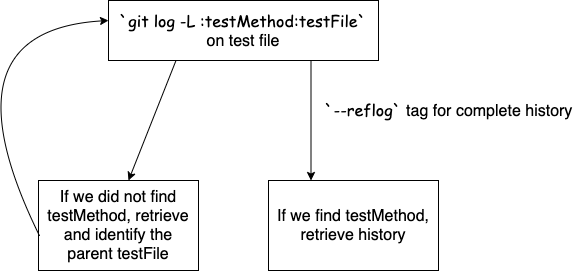

*Three triggering tests was manually collected* (due to PR merge from another repository, which is invisible through `git log`): 
- Math 6 GaussNewtonOptimizerTest testGetIterations
- Math 6 LevenbergMarquardtOptimizerTest testGetIterations
- Mockito 7 DeepStubFailingWhenGenricNestedAsRawTypeTest 

In [371]:
%run utils.ipynb

import re
import os
import glob

def find_files(filename, search_path):
    result = []
    for root, dir, files in os.walk(search_path):
        if filename in files:
            result.append(os.path.join(root, filename))
    return result

def add_gitattributes(proj_repo):
    gita_file = os.path.join(proj_repo, ".gitattributes")
    java_attribute = "*.java text diff=java"
    
    with open(gita_file, "w+") as file:
        for line in file:
            if java_attribute in line:
                break
        # end of file
        else:
            file.write(java_attribute)
    
def setup_out_folder(out_repo, list_identifiers):
    out_dir = os.path.join(out_repo, 'triggering_tests_commit')
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    return os.path.join(out_dir, '_'.join(list_identifiers))

def find_parent_test(test, test_file):
    content = None
    with open(test_file, encoding='latin-1') as f:
         content = f.read()
    match = re.search(re.escape(test) + r'\s+extends\s+(\w+)', content)
    if match == 'TestCase' or not match:
        return None
    return match.group(1)

def select_log_option(project, out_repo):
    # for jsoup project, -L isn't working very well, let's use -G to capture the regex directly
    if not project or project == 'Jsoup':
        return os.path.join(code_repo, 'git_log_g_fn.sh')
    return os.path.join(code_repo, 'git_log_fn.sh')

def execute_git_log(git_log_fn_sh, proj_repo, test, test_method, test_file):
    
    # look for parent test if func not available in the test file
    while not (output := execute_shell([git_log_fn_sh, proj_repo, test_method, test_file])):
        parent_test = find_parent_test(test, test_file)

        if not parent_test:
            print('\tmissing parent test!')
            return

        search_results = find_files(parent_test+".java", proj_repo)

        if not search_results:
            print('\tmissing parent test!')
            return

        test = parent_test
        # todo: there might be multiple parent test class
        test_file = search_results[0]
        print('\tgit log -L :{}:{}'.format(test_method, test_file))
    return output

test_git_log_test_on = []
triggering_tests_commit = []
# for i, row in df[(df['project']=='Math') & (df['id']==6)].iterrows():
for i, row in df.iterrows():
    
    project, bugid, test, test_full, test_method = row
    original_test = test
    print(project, bugid, test, test_method)
    proj_repo = glob.glob(active_repo+'/*'+project.lower()+'*')[0]
    #print(proj_repo)

    output_file = setup_out_folder(out_repo, [project, str(bugid), test, test_method, '.txt'])
    
    # todo: remove the always False
    if os.path.exists(output_file):
        with open(output_file, 'r') as file:
            # read and continue
            output = file.read()
    else:
        # checkout at the bug fix commit, the test case must exists there
        # read from bug_fix.csv
        bug_fix_commit = df_fixes[(df_fixes.proj == project) & (df_fixes.id == bugid)]
        if bug_fix_commit.empty:
            print('\t', 'missing bug fix commit')
            continue
        bug_fix_commit = bug_fix_commit.iloc[0]['commit']        

        # checkout
        print('\tgit checkout', bug_fix_commit)
        git_checkout_sh = os.path.join(code_repo, 'git_checkout.sh')
        output = execute_shell([git_checkout_sh, proj_repo, bug_fix_commit])

        # add attribute file
        print('\tadd .gitattributes')
        add_gitattributes(proj_repo)

        # search file
        print('\tsearch file')
        search_results = find_files(test+".java", proj_repo)
        if not search_results:
            print('\tmissing test!')
            continue
            
        # loop all search files
        for test_file in search_results:
            # quick check if string in file
            with open(test_file, encoding = 'ISO-8859-1') as file:
                if test_method not in file.read():
                    print('\tfound test file, but missing test method')

            # git log -L :func:file
            print('\tgit log -L :"{}":{}'.format(test_method+'(', test_file))
            git_log_fn_sh = select_log_option(project, code_repo)
            output = execute_git_log(git_log_fn_sh, proj_repo, test, test_method+'(', test_file)

            if output:
                with open(output_file, 'w') as writer:
                    writer.write(output)
                    break
    
    if not output:
        print('\tgit log -G')
        git_log_fn_sh = select_log_option(None, code_repo)
        output = execute_git_log(git_log_fn_sh, proj_repo, test, test_method, test_file)
        if output:
            with open(output_file, 'w') as writer:
                writer.write(output)
        else:
            print('!!!something wrong, git log -G did not work neither')
            print('\tgit log -G {} --reflog -p -- {}'.format(test_method, test_file))
            continue
    
    # ignore first spacing
    result = re.split(r'(commit(.*)\nAuthor:(.*)\nDate:(.*))', output)[1:]
    # join every first and fifth (step value: 5)
    result = ['\n'.join(x) for x in zip(result[::5], result[4::5])]
    
    # found: used to verify if any commit has been added already
    found = False
    # the matching list `result` from output_file is order from the most recent to the oldest, we should get the oldest added time.
    # Here, we reverse the list and get the first (i.e., the oldest) commit first and look whether there is a test_method addition match
    for r in reversed(result):
        added = False
        # check if test_method has been added in this commit match
        if not found and re.search(r'\+(\s|\w|@)*' + re.escape(test_method) + '\(', r):
            found, added = True, True
            print('\t', added)
        for match in re.finditer(r"(?m)commit(.*)\nAuthor:(.*)\nDate:(.*)", r):
            triggering_tests_commit.append([project, bugid, original_test, test_method, match.group(1).strip(), match.group(2).strip(), match.group(3).strip(), added])
            print('\t', match, added)

Cli 32 HelpFormatterTest testRenderWrappedTextWordCut
	 <re.Match object; span=(0, 126), match='commit aae50c585ec3ac33c6a9af792e80378904a73195\n> False
	 <re.Match object; span=(0, 119), match='commit 4cca25d72b216bfc8f2e75e4a99afb608ceb6df8\n> False
	 <re.Match object; span=(0, 119), match='commit c7127329dad2c5d6284532da09ddc0fdefd67436\n> False
	 <re.Match object; span=(0, 118), match='commit 9b2b8038b52be022e42c8c7fdf26e236888f94c5\n> False
	 <re.Match object; span=(0, 121), match='commit 6f972cf56d7a3054bac902fecb6d3dd5ee310dea\n> False
	 <re.Match object; span=(0, 121), match='commit 7d52b84bd4399872c37c6c0fc3936ff7a7415c6a\n> False
	 <re.Match object; span=(0, 121), match='commit 4f407378c93b9e2a8e24c855e8bed5eb12bf7a06\n> False
	 <re.Match object; span=(0, 123), match='commit 2490250f9b3044e4cd946f11b46694f943f5814d\n> False
	 <re.Match object; span=(0, 123), match='commit 1042ba35258c9fcfa9f14ccd240d0d1212a2e3ce\n> False
	 True
	 <re.Match object; span=(0, 122), match='commit

In [372]:
import os
import pandas as pd

triggering_tests_commits_file = os.path.join(out_repo, 'triggering_tests_commit.csv')
df_triggering_test_commits = pd.DataFrame(triggering_tests_commit, columns=['project', 'bugid', 'test', 'test_method', 'commit', 'author', 'date', 'created'])
# as we look for the git log history for each test method, when their test parent is the same, there might be duplicate
df_triggering_test_commits.drop_duplicates(inplace=True)
df_triggering_test_commits.to_csv(triggering_tests_commits_file, index=False)

In [373]:
import os
import pandas as pd

triggering_tests_commits_file = os.path.join(out_repo, 'triggering_tests_commit.csv')
df_triggering_test_commits = pd.read_csv(triggering_tests_commits_file)
df_triggering_test_commits

,project,bugid,test,test_method,commit,author,date,created
0,Cli,32,HelpFormatterTest,testRenderWrappedTextWordCut,aae50c585ec3ac33c6a9af792e80378904a73195,James Strachan <jstrachan@apache.org>,Mon Jun 10 14:01:16 2002,False
1,Cli,32,HelpFormatterTest,testRenderWrappedTextWordCut,4cca25d72b216bfc8f2e75e4a99afb608ceb6df8,John Keyes <jkeyes@apache.org>,Sun Jun 16 19:00:59 2002,False
2,Cli,32,HelpFormatterTest,testRenderWrappedTextWordCut,c7127329dad2c5d6284532da09ddc0fdefd67436,John Keyes <jkeyes@apache.org>,Mon Jul 22 18:49:58 2002,False
3,Cli,32,HelpFormatterTest,testRenderWrappedTextWordCut,9b2b8038b52be022e42c8c7fdf26e236888f94c5,John Keyes <jkeyes@apache.org>,Mon Dec 9 18:47:26 2002,False
4,Cli,32,HelpFormatterTest,testRenderWrappedTextWordCut,6f972cf56d7a3054bac902fecb6d3dd5ee310dea,Henri Yandell <bayard@apache.org>,Wed Jun 6 04:01:19 2007,False
...,...,...,...,...,...,...,...,...
3886,Time,25,TestDateTimeZoneCutover,test_DateTime_constructor_Moscow_Autumn,552be4b677ec30a34d04d234395ba1a8c7beaacf,Stephen Colebourne <scolebourne@joda.org>,Sun Dec 5 18:43:18 2010,True
3887,Time,25,TestDateTimeZoneCutover,test_getOffsetFromLocal_Moscow_Autumn_overlap_...,c41eff1e6026a6e0b88ea45edda3e41eecc6ac7b,Stephen Colebourne <scolebourne@joda.org>,Sat Aug 4 13:23:22 2007,False
3888,Time,25,TestDateTimeZoneCutover,test_getOffsetFromLocal_Moscow_Autumn_overlap_...,552be4b677ec30a34d04d234395ba1a8c7beaacf,Stephen Colebourne <scolebourne@joda.org>,Sun Dec 5 18:43:18 2010,True
3889,Time,25,TestDateTimeZoneCutover,test_getOffsetFromLocal_Moscow_Autumn,c41eff1e6026a6e0b88ea45edda3e41eecc6ac7b,Stephen Colebourne <scolebourne@joda.org>,Sat Aug 4 13:23:22 2007,False


In [305]:
df_new = df_triggering_test_commits[['project', 'bugid']].copy().drop_duplicates()
df_new

,project,bugid
0,Cli,32
22,Cli,35
23,Cli,34
28,Cli,33
29,Cli,20
...,...,...
3863,Time,13
3865,Time,5
3869,Time,14
3877,Time,22


In [137]:
df_test_git_log_test_on = pd.DataFrame(test_git_log_test_on, columns=['project', 'bugid', 'test', 'test_method', 'bug_fix_commit'])
display(df_test_git_log_test_on)

,project,bugid,test,test_method,bug_fix_commit
0,Cli,27,BasicParserTest,testOptionGroupLong,4c971f08861e8cefb8ca9ac20799bfdad4e973a4
1,Cli,27,GnuParserTest,testOptionGroupLong,4c971f08861e8cefb8ca9ac20799bfdad4e973a4
2,Cli,27,PosixParserTest,testOptionGroupLong,4c971f08861e8cefb8ca9ac20799bfdad4e973a4
3,Cli,16,DefaultingCommandLineTest,testGetOptions_Order,f104dd060c6c88450ac9ee9eb818b26374512440
4,Cli,16,PreferencesCommandLineTest,testGetOptions_Order,f104dd060c6c88450ac9ee9eb818b26374512440
...,...,...,...,...,...
170,Math,22,UniformRealDistributionTest,testIsSupportUpperBoundInclusive,b0cba9a79ee99b09958dec8e40c75bed47b7f780
171,Mockito,26,HandyReturnValuesTest,should_default_values_for_primitive,af44738c7de74f24e37ea0c1242e73b07c3f4362
172,Mockito,26,ReturnsEmptyValuesTest,should_return_primitive,af44738c7de74f24e37ea0c1242e73b07c3f4362
173,Mockito,21,ConstructorInstantiatorTest,creates_instances_of_inner_classes,8912aa176ea8414c2fc57df0d9b030b918630e9f


##### sample on how commit log was processed

In [226]:
test_file = os.path.join(out_repo, 'triggering_tests_commit/Cli_25_BugCLI162Test_testLongLineChunkingIndentIgnored_.txt')

string = None
if os.path.exists(test_file):
    with open(test_file, 'r') as file:
        # read and continue
        string = file.read()
        
# ignore first empty space
result = re.split(r"(commit(.*)\nAuthor:(.*)\nDate:(.*))", string)[1:]

# list of one's and fourth's that contain the string information
result = ['\n'.join(x) for x in zip(result[::5], result[4::5])]
print(result[2])
# r = '\n'.join(result[1::2])
# print(r)

commit 84234a65638f0e9e4be73dfcccaa6530a5b571af
Author: Henri Yandell <bayard@apache.org>
Date:   Fri Feb 20 00:00:59 2009


    Applying additional patch to throw IllegalStateException when the specified width is not enough to fit the flags, indent and 1 character for the description. This closes out CLI-162 (for now :) ).
    
    git-svn-id: https://svn.apache.org/repos/asf/commons/proper/cli/branches/cli-1.x@746137 13f79535-47bb-0310-9956-ffa450edef68

diff --git a/src/test/org/apache/commons/cli/bug/BugCLI162Test.java b/src/test/org/apache/commons/cli/bug/BugCLI162Test.java
--- a/src/test/org/apache/commons/cli/bug/BugCLI162Test.java
+++ b/src/test/org/apache/commons/cli/bug/BugCLI162Test.java
@@ -262,3 +263,10 @@
+        try {
+            formatter.printHelp(new PrintWriter(sw), 22, this.getClass().getName(), "Header", options, 0, 5, "Footer");
+            fail("IllegalStateException expected");
+        } catch(IllegalStateException ise) {
+            // expected
+        }


##### One way to verify and clean the data

We can retrieve the bug fixing patches, check if the test method is only added on the bug fix. If so, remove other commits on the triggering tests.
Up to this point, we have collected all commits that relevant to the test (at least test files). Now, to make sure the *test methods* are created on the right commits, we need to loop through the resulting data to locate the first one.

In [311]:
import os
import pandas as pd

def setup_out_folder(out_repo, list_identifiers):
    out_dir = os.path.join(out_repo, 'bug_fix')
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    return os.path.join(out_dir, '_'.join(list_identifiers))

new_test_method = []
for i, row in df.iterrows():
    project, bugid, test, test_full, test_method = row
    print(project, bugid, test, test_method)
    proj_repo = glob.glob(active_repo+'/*'+project.lower()+'*')[0]
    print(proj_repo)

    output_file = setup_out_folder(out_repo, [project, str(bugid), '.txt'])
    
    # checkout at the bug fix commit, the test case must exists there
    # read from bug_fix.csv
    bug_fix_commit = df_fixes[(df_fixes.proj == project) & (df_fixes.id == bugid)]
    if bug_fix_commit.empty:
        print('\t', 'missing bug fix commit')
        continue
    bug_fix_commit = bug_fix_commit.iloc[0]['commit']
    
    if os.path.exists(output_file):
        with open(output_file, 'r') as file:
            # read and continue
            output = file.read()
    else:
        # checkout
        print('\tgit show', bug_fix_commit)
        git_show_sh = os.path.join(code_repo, 'git_show.sh')
        output = execute_shell([git_show_sh, proj_repo, bug_fix_commit])

        # save output for debugging if needed
        if output:
            with open(output_file, 'w') as writer:
                writer.write(output)
    
    date = "Date:\s+(.*)"
    # regex, find if test method was added
    result = re.split(r'diff --git.*', output)
    for r in result:
        if test not in r:
            continue
        if re.search(r'\+(\s|\w)*' + re.escape(test_method) + '\(', r):
            new_test_method.append([project, bugid, test, test_method, bug_fix_commit])
    
df_new_test_method = pd.DataFrame(new_test_method, columns=['project', 'bugid', 'test', 'test_method', 'bug_fix_commit'])


Cli 32 HelpFormatterTest testRenderWrappedTextWordCut
/Users/IceCream/Documents/defects4j_projects/commons-cli
Cli 32 HelpFormatterTest testFindWrapPos
/Users/IceCream/Documents/defects4j_projects/commons-cli
Cli 35 BugCLI252Test testExactOptionNameMatch
/Users/IceCream/Documents/defects4j_projects/commons-cli
Cli 34 CommandLineTest testGetParsedOptionValue
/Users/IceCream/Documents/defects4j_projects/commons-cli
Cli 34 OptionBuilderTest testTwoCompleteOptions
/Users/IceCream/Documents/defects4j_projects/commons-cli
Cli 33 HelpFormatterTest testIndentedHeaderAndFooter
/Users/IceCream/Documents/defects4j_projects/commons-cli
Cli 20 PosixParserTest testStop3
/Users/IceCream/Documents/defects4j_projects/commons-cli
Cli 18 PosixParserTest testStop2
/Users/IceCream/Documents/defects4j_projects/commons-cli
Cli 27 BasicParserTest testOptionGroupLong
/Users/IceCream/Documents/defects4j_projects/commons-cli
Cli 27 GnuParserTest testOptionGroupLong
/Users/IceCream/Documents/defects4j_projects/co

In [313]:
new_test_method = os.path.join(out_repo, 'commits_with_new_test_methods.csv')
df_new_test_method.to_csv(new_test_method, index=False)

In [314]:
df_new_test_method

,project,bugid,test,test_method,bug_fix_commit
0,Cli,32,HelpFormatterTest,testRenderWrappedTextWordCut,777cb81088d47472df21a452edd5ba568d4b3fdf
1,Cli,35,BugCLI252Test,testExactOptionNameMatch,085a1538fa20d8e48faad49eaffd697f024bf1af
2,Cli,34,CommandLineTest,testGetParsedOptionValue,62a3b36efc78e53c233c2fb49cc8199c5eabec1d
3,Cli,33,HelpFormatterTest,testIndentedHeaderAndFooter,483f811dfefdc6bee162481425f261d983f15e4a
4,Cli,20,PosixParserTest,testStop3,99aa05af2bfef3980ad8f94230cd077e8d30c5ea
...,...,...,...,...,...
818,Time,22,TestDuration_Basics,testToPeriod_fixedZone,57c8aaf94b95323c295dcfec5f40f181846164e7
819,Time,22,TestPeriod_Constructors,testConstructor_long_fixedZone,57c8aaf94b95323c295dcfec5f40f181846164e7
820,Time,25,TestDateTimeZoneCutover,test_DateTime_constructor_Moscow_Autumn,552be4b677ec30a34d04d234395ba1a8c7beaacf
821,Time,25,TestDateTimeZoneCutover,test_getOffsetFromLocal_Moscow_Autumn_overlap_...,552be4b677ec30a34d04d234395ba1a8c7beaacf


### Changes details on the triggering tests

Available in `triggering_tests_commit` folder

### Re-constructing the timestamps

1. look for test modifications that happen in between bug creation and ~~bug resolution time~~ bug fix commit
2. check if it is the first commit, if so, then the test has just been created

[created_in, modified_in]

- Pattern 1: [true, false]
- Pattern 2: [true, true]
- Pattern 3: [false, true]
- Pattern 4: [false, false]

##### Data overview

In [21]:
import os
import pandas as pd

triggering_tests_commits_file = os.path.join(out_repo, 'triggering_tests_commit.csv')
df_triggering_test_commits = pd.read_csv(triggering_tests_commits_file)
print('Tests:', len(df_triggering_test_commits.groupby(['project', 'bugid', 'test', 'test_method']).size()))

df_triggering_test_commits['date'] = pd.to_datetime(df_triggering_test_commits['date'], format='%a %b %d %H:%M:%S %Y')
df_triggering_test_commits['date'] = df_triggering_test_commits['date'].dt.tz_localize(tz='US/Eastern')
df_triggering_test_commits['date'] = df_triggering_test_commits['date'].dt.tz_convert('UTC')


df_test = df_triggering_test_commits.groupby(['project', 'bugid', 'test', 'test_method']).agg({'date': list, 'commit': list, 'created': list}).reset_index()
df_test.rename(columns={"date": "datetime_modified", "commit": "commit_modified"}, inplace=True)
df_test.to_csv(os.path.join(out_repo, 'triggering_tests_commit_concat.csv'), index=False)

df_test

Tests: 1659


,project,bugid,test,test_method,datetime_modified,commit_modified,created
0,Cli,1,BugCLI13Test,testCLI13,[2007-05-15 00:47:38+00:00],[b0e1b80b6d4a10a9c9f46539bc4c7a3cce55886e],[True]
1,Cli,2,BugCLI51Test,test,[2007-05-22 17:47:16+00:00],[2ff9573ffb08dd52ec3a55a49f2d77a1e94efbdf],[True]
2,Cli,3,PatternOptionBuilderTest,testSimplePattern,"[2002-06-10 18:01:16+00:00, 2002-06-16 23:00:5...","[aae50c585ec3ac33c6a9af792e80378904a73195, 4cc...","[True, False, False, False, False, False, False]"
3,Cli,4,OptionsTest,testMissingOptionException,"[2002-11-19 00:16:18+00:00, 2007-06-05 04:01:0...","[0f52eff086c74ad246c23a82f01b39a39c107ffa, f78...","[False, True]"
4,Cli,4,OptionsTest,testMissingOptionsException,"[2002-11-19 00:16:18+00:00, 2007-06-05 04:01:0...","[0f52eff086c74ad246c23a82f01b39a39c107ffa, f78...","[False, True]"
...,...,...,...,...,...,...,...
1654,Time,26,TestDateTimeZoneCutover,testWithMillisOfSecondInDstChange_Paris_summer,[2010-12-05 21:27:36+00:00],[c7a581e55fc988bd90fa4bb1b0acece5181b7c5f],[True]
1655,Time,26,TestDateTimeZoneCutover,testWithMinuteOfHourInDstChange,[2010-12-05 21:27:36+00:00],[c7a581e55fc988bd90fa4bb1b0acece5181b7c5f],[False]
1656,Time,26,TestDateTimeZoneCutover,testWithMinuteOfHourInDstChange_mockZone,[2010-12-05 21:27:36+00:00],[c7a581e55fc988bd90fa4bb1b0acece5181b7c5f],[True]
1657,Time,26,TestDateTimeZoneCutover,testWithSecondOfMinuteInDstChange,[2010-12-05 21:27:36+00:00],[c7a581e55fc988bd90fa4bb1b0acece5181b7c5f],[True]


In [22]:
bug_mining_file = os.path.join(out_repo, 'bug_mining.csv')
# ignore index
df_bug = pd.read_csv(bug_mining_file).iloc[:, 1:]
# 

df = df_test.merge(df_bug, left_on=['project', 'bugid'], right_on=['project', 'id'], how='left')
# drop nan report creation/resolution
print('Report creation/resolution is NaN:', len(df[df['report_creation'].isna() | df['report_resolution'].isna()]))
df[df['report_creation'].isna() | df['report_resolution'].isna()].to_csv(os.path.join(out_repo, 'bug_mining_manual.csv'))

df = df[df['report_creation'].notna() & df['report_resolution'].notna()]
df['report_creation'] = pd.to_datetime(df['report_creation'])
df['report_resolution'] = pd.to_datetime(df['report_resolution'])

df

Report creation/resolution is NaN: 4


,project,bugid,test,test_method,datetime_modified,commit_modified,created,id,report_creation,report_resolution,revision_id_buggy,revision_id_fixed,report_id,report_url
0,Cli,1,BugCLI13Test,testCLI13,[2007-05-15 00:47:38+00:00],[b0e1b80b6d4a10a9c9f46539bc4c7a3cce55886e],[True],1.0,2005-10-11 02:06:11,2007-05-22 17:48:43,8f46f467a33ace44ccd9f394910940b6c48a3827,b0e1b80b6d4a10a9c9f46539bc4c7a3cce55886e,CLI-13,https://issues.apache.org/jira/browse/CLI-13
1,Cli,2,BugCLI51Test,test,[2007-05-22 17:47:16+00:00],[2ff9573ffb08dd52ec3a55a49f2d77a1e94efbdf],[True],2.0,2005-05-10 10:50:14,2007-05-22 17:47:28,b0e1b80b6d4a10a9c9f46539bc4c7a3cce55886e,2ff9573ffb08dd52ec3a55a49f2d77a1e94efbdf,CLI-51,https://issues.apache.org/jira/browse/CLI-51
2,Cli,3,PatternOptionBuilderTest,testSimplePattern,"[2002-06-10 18:01:16+00:00, 2002-06-16 23:00:5...","[aae50c585ec3ac33c6a9af792e80378904a73195, 4cc...","[True, False, False, False, False, False, False]",3.0,2002-10-24 22:32:22,2007-03-15 16:49:08,85248e8ae52232ed75c2b4c52d4071bdf192db37,d35f2fa7a06457469a617677eeb4c1dc21484006,cli-1,https://issues.apache.org/jira/browse/CLI-1
3,Cli,4,OptionsTest,testMissingOptionException,"[2002-11-19 00:16:18+00:00, 2007-06-05 04:01:0...","[0f52eff086c74ad246c23a82f01b39a39c107ffa, f78...","[False, True]",4.0,2002-10-24 22:32:22,2007-03-15 16:49:08,8ca630b76ebcfe24915a9edb3a6de756cab761c9,f78959477b207bf710049aa35730ef7659f0a1b9,cli-1,https://issues.apache.org/jira/browse/CLI-1
4,Cli,4,OptionsTest,testMissingOptionsException,"[2002-11-19 00:16:18+00:00, 2007-06-05 04:01:0...","[0f52eff086c74ad246c23a82f01b39a39c107ffa, f78...","[False, True]",4.0,2002-10-24 22:32:22,2007-03-15 16:49:08,8ca630b76ebcfe24915a9edb3a6de756cab761c9,f78959477b207bf710049aa35730ef7659f0a1b9,cli-1,https://issues.apache.org/jira/browse/CLI-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,Time,26,TestDateTimeZoneCutover,testWithMillisOfSecondInDstChange_Paris_summer,[2010-12-05 21:27:36+00:00],[c7a581e55fc988bd90fa4bb1b0acece5181b7c5f],[True],26.0,2008-10-20 14:11:00,2010-12-05 21:29:59,218a7fe91a685e089ab8fd7700806f7a6083f18d,c7a581e55fc988bd90fa4bb1b0acece5181b7c5f,60,https://sourceforge.net/p/joda-time/bugs/60
1655,Time,26,TestDateTimeZoneCutover,testWithMinuteOfHourInDstChange,[2010-12-05 21:27:36+00:00],[c7a581e55fc988bd90fa4bb1b0acece5181b7c5f],[False],26.0,2008-10-20 14:11:00,2010-12-05 21:29:59,218a7fe91a685e089ab8fd7700806f7a6083f18d,c7a581e55fc988bd90fa4bb1b0acece5181b7c5f,60,https://sourceforge.net/p/joda-time/bugs/60
1656,Time,26,TestDateTimeZoneCutover,testWithMinuteOfHourInDstChange_mockZone,[2010-12-05 21:27:36+00:00],[c7a581e55fc988bd90fa4bb1b0acece5181b7c5f],[True],26.0,2008-10-20 14:11:00,2010-12-05 21:29:59,218a7fe91a685e089ab8fd7700806f7a6083f18d,c7a581e55fc988bd90fa4bb1b0acece5181b7c5f,60,https://sourceforge.net/p/joda-time/bugs/60
1657,Time,26,TestDateTimeZoneCutover,testWithSecondOfMinuteInDstChange,[2010-12-05 21:27:36+00:00],[c7a581e55fc988bd90fa4bb1b0acece5181b7c5f],[True],26.0,2008-10-20 14:11:00,2010-12-05 21:29:59,218a7fe91a685e089ab8fd7700806f7a6083f18d,c7a581e55fc988bd90fa4bb1b0acece5181b7c5f,60,https://sourceforge.net/p/joda-time/bugs/60


In [23]:
df_new_test_method = pd.read_csv(os.path.join(out_repo, 'commits_with_new_test_methods.csv'))
df_new_test_method

,project,bugid,test,test_method,bug_fix_commit
0,Cli,32,HelpFormatterTest,testRenderWrappedTextWordCut,777cb81088d47472df21a452edd5ba568d4b3fdf
1,Cli,35,BugCLI252Test,testExactOptionNameMatch,085a1538fa20d8e48faad49eaffd697f024bf1af
2,Cli,34,CommandLineTest,testGetParsedOptionValue,62a3b36efc78e53c233c2fb49cc8199c5eabec1d
3,Cli,33,HelpFormatterTest,testIndentedHeaderAndFooter,483f811dfefdc6bee162481425f261d983f15e4a
4,Cli,20,PosixParserTest,testStop3,99aa05af2bfef3980ad8f94230cd077e8d30c5ea
...,...,...,...,...,...
818,Time,22,TestDuration_Basics,testToPeriod_fixedZone,57c8aaf94b95323c295dcfec5f40f181846164e7
819,Time,22,TestPeriod_Constructors,testConstructor_long_fixedZone,57c8aaf94b95323c295dcfec5f40f181846164e7
820,Time,25,TestDateTimeZoneCutover,test_DateTime_constructor_Moscow_Autumn,552be4b677ec30a34d04d234395ba1a8c7beaacf
821,Time,25,TestDateTimeZoneCutover,test_getOffsetFromLocal_Moscow_Autumn_overlap_...,552be4b677ec30a34d04d234395ba1a8c7beaacf


##### Preprocessing on df for `created`

In [24]:
def reduce(row):
    project, bugid, test, method, datetime_modified, created, commit_modified = row
    if True in created:
        index = created.index(True)
    else:
        print('\tmissing True', project, bugid, test, method, datetime_modified, created, commit_modified)
        return datetime_modified, created, commit_modified
    
    datetime_modified = datetime_modified[index:]
    commit_modified = commit_modified[index:]
    created = created[index:]
    #print('\t', datetime_modified, commit_modified, created)
    return datetime_modified, created, commit_modified
    
df[['datetime_modified', 'created', 'commit_modified']] = df[['project', 'bugid', 'test', 'test_method', 'datetime_modified', 'created', 'commit_modified']].apply(lambda row: reduce(row), axis=1, result_type='expand')
print('Is all first datetime_modified the creation date: {}'.format(all(l[0][0] for l in df[['created']].values)))

df

	missing True Time 26 TestDateTimeZoneCutover testWithMinuteOfHourInDstChange [Timestamp('2010-12-05 21:27:36+0000', tz='UTC')] [False] ['c7a581e55fc988bd90fa4bb1b0acece5181b7c5f']
Is all first datetime_modified the creation date: False


,project,bugid,test,test_method,datetime_modified,commit_modified,created,id,report_creation,report_resolution,revision_id_buggy,revision_id_fixed,report_id,report_url
0,Cli,1,BugCLI13Test,testCLI13,[2007-05-15 00:47:38+00:00],[b0e1b80b6d4a10a9c9f46539bc4c7a3cce55886e],[True],1.0,2005-10-11 02:06:11,2007-05-22 17:48:43,8f46f467a33ace44ccd9f394910940b6c48a3827,b0e1b80b6d4a10a9c9f46539bc4c7a3cce55886e,CLI-13,https://issues.apache.org/jira/browse/CLI-13
1,Cli,2,BugCLI51Test,test,[2007-05-22 17:47:16+00:00],[2ff9573ffb08dd52ec3a55a49f2d77a1e94efbdf],[True],2.0,2005-05-10 10:50:14,2007-05-22 17:47:28,b0e1b80b6d4a10a9c9f46539bc4c7a3cce55886e,2ff9573ffb08dd52ec3a55a49f2d77a1e94efbdf,CLI-51,https://issues.apache.org/jira/browse/CLI-51
2,Cli,3,PatternOptionBuilderTest,testSimplePattern,"[2002-06-10 18:01:16+00:00, 2002-06-16 23:00:5...","[aae50c585ec3ac33c6a9af792e80378904a73195, 4cc...","[True, False, False, False, False, False, False]",3.0,2002-10-24 22:32:22,2007-03-15 16:49:08,85248e8ae52232ed75c2b4c52d4071bdf192db37,d35f2fa7a06457469a617677eeb4c1dc21484006,cli-1,https://issues.apache.org/jira/browse/CLI-1
3,Cli,4,OptionsTest,testMissingOptionException,[2007-06-05 04:01:08+00:00],[f78959477b207bf710049aa35730ef7659f0a1b9],[True],4.0,2002-10-24 22:32:22,2007-03-15 16:49:08,8ca630b76ebcfe24915a9edb3a6de756cab761c9,f78959477b207bf710049aa35730ef7659f0a1b9,cli-1,https://issues.apache.org/jira/browse/CLI-1
4,Cli,4,OptionsTest,testMissingOptionsException,[2007-06-05 04:01:08+00:00],[f78959477b207bf710049aa35730ef7659f0a1b9],[True],4.0,2002-10-24 22:32:22,2007-03-15 16:49:08,8ca630b76ebcfe24915a9edb3a6de756cab761c9,f78959477b207bf710049aa35730ef7659f0a1b9,cli-1,https://issues.apache.org/jira/browse/CLI-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,Time,26,TestDateTimeZoneCutover,testWithMillisOfSecondInDstChange_Paris_summer,[2010-12-05 21:27:36+00:00],[c7a581e55fc988bd90fa4bb1b0acece5181b7c5f],[True],26.0,2008-10-20 14:11:00,2010-12-05 21:29:59,218a7fe91a685e089ab8fd7700806f7a6083f18d,c7a581e55fc988bd90fa4bb1b0acece5181b7c5f,60,https://sourceforge.net/p/joda-time/bugs/60
1655,Time,26,TestDateTimeZoneCutover,testWithMinuteOfHourInDstChange,[2010-12-05 21:27:36+00:00],[c7a581e55fc988bd90fa4bb1b0acece5181b7c5f],[False],26.0,2008-10-20 14:11:00,2010-12-05 21:29:59,218a7fe91a685e089ab8fd7700806f7a6083f18d,c7a581e55fc988bd90fa4bb1b0acece5181b7c5f,60,https://sourceforge.net/p/joda-time/bugs/60
1656,Time,26,TestDateTimeZoneCutover,testWithMinuteOfHourInDstChange_mockZone,[2010-12-05 21:27:36+00:00],[c7a581e55fc988bd90fa4bb1b0acece5181b7c5f],[True],26.0,2008-10-20 14:11:00,2010-12-05 21:29:59,218a7fe91a685e089ab8fd7700806f7a6083f18d,c7a581e55fc988bd90fa4bb1b0acece5181b7c5f,60,https://sourceforge.net/p/joda-time/bugs/60
1657,Time,26,TestDateTimeZoneCutover,testWithSecondOfMinuteInDstChange,[2010-12-05 21:27:36+00:00],[c7a581e55fc988bd90fa4bb1b0acece5181b7c5f],[True],26.0,2008-10-20 14:11:00,2010-12-05 21:29:59,218a7fe91a685e089ab8fd7700806f7a6083f18d,c7a581e55fc988bd90fa4bb1b0acece5181b7c5f,60,https://sourceforge.net/p/joda-time/bugs/60


##### Processing

In [25]:
import numpy as np

# check if the test is modified in between the bug creation and resolution, and the modification should not be its creation
def is_modified_in(row):
    datetime_modified, report_creation, report_resolution, created = row['datetime_modified'], row['report_creation'], row['report_resolution'], row['created']
    # creation and modification happens on the same timestamps
    more_than_one_creation = sum(a_datetime == min(datetime_modified) for a_datetime in datetime_modified) > 1

    report_creation = report_creation.tz_localize('UTC')
    report_resolution = report_resolution.tz_localize('UTC')
    
    return any((
        # condition 1: modification happens betwen creation and resolution
        report_creation < a_datetime < report_resolution
    ) and (
        # condition 2: either [1. more than one commit has the same creation time] or [2. the creation time is different from the modification time]
        (more_than_one_creation and a_datetime == min(datetime_modified)) or (a_datetime > min(datetime_modified))
    ) for a_datetime in datetime_modified)

# check if the test is created in between the bug creation and resolution
def is_created_in(row):
    #if row['created_in'] == True:
    #    return True
    datetime_modified, report_creation, report_resolution = row['datetime_modified'], row['report_creation'], row['report_resolution']
    # min(datetime_modified) = creation datetime
    # check if creation datetime is between bug creation and resolution
    
    report_creation = report_creation.tz_localize('UTC')
    report_resolution = report_resolution.tz_localize('UTC')
    
    return report_creation < min(datetime_modified) < report_resolution

def set_pattern(row):
    if row['created_in'] and not row['modified_in']:
        return 1
    elif row['created_in'] and row['modified_in']:
        return 2
    elif not row['created_in'] and row['modified_in']:
        return 3
    elif not row['created_in'] and not row['modified_in']:
        return 4

df['created_in'] = [is_created_in(row) for index, row in df.iterrows()]
df['modified_in'] = [is_modified_in(row) for index, row in df.iterrows()]

In [26]:
# import numpy as np

# # check if the test is modified in between the bug creation and resolution, and the modification should not be its creation
# def is_modified_in(row):
#     datetime_modified, report_creation, report_resolution = row['datetime_modified'], row['report_creation'], row['report_resolution']
#     # creation and modification happens on the same timestamps
#     more_than_one_creation = sum(a_datetime == min(datetime_modified) for a_datetime in datetime_modified) > 1

#     return any((
#         # condition 1: modification happens betwen creation and resolution
#         report_creation < a_datetime < report_resolution
#     ) and (
#         # condition 2: either [1. more than one commit has the same creation time] or [2. the creation time is different from the modification time]
#         (more_than_one_creation and a_datetime == min(datetime_modified)) or (a_datetime > min(datetime_modified))
#     ) for a_datetime in datetime_modified)

# # check if the test is created in between the bug creation and resolution
# def is_created_in(row):
#     if row['created_in'] == True:
#         return True
#     datetime_modified, report_creation, report_resolution = row['datetime_modified'], row['report_creation'], row['report_resolution']
#     # min(datetime_modified) = creation datetime
#     # check if creation datetime is between bug creation and resolution
#     return report_creation < min(datetime_modified) < report_resolution

# def set_pattern(row):
#     if row['created_in'] and not row['modified_in']:
#         return 1
#     elif row['created_in'] and row['modified_in']:
#         return 2
#     elif not row['created_in'] and row['modified_in']:
#         return 3
#     elif not row['created_in'] and not row['modified_in']:
#         return 4

# df_pattern = pd.merge(df, df_new_test_method, on=['project', 'bugid', 'test', 'test_method'], how='left', indicator='Exist')
# df_pattern['created_in'] = df_pattern.apply(lambda row: True if row['Exist'] == 'both' else False, axis=1)
# df_pattern['datetime_modified'] = df_pattern['datetime_modified'].sort_values().apply(lambda x: sorted(x))
# # add new creation date in, remove everything that comes before the new date
# df_pattern['datetime_modified'] = df_pattern.apply(lambda row: row['datetime_modified'][row['datetime_modified'].index(row['bug_fix_commit'])+1:] if row['bug_fix_commit'] and row['bug_fix_commit'] in row['datetime_modified'] else row['datetime_modified'], axis=1)

# df_pattern['created_in'] = [is_created_in(row) for index, row in df_pattern.iterrows()]
# df_pattern['modified_in'] = [is_modified_in(row) for index, row in df_pattern.iterrows()]

In [27]:
df_pattern[df_pattern['bugid']==8]

NameError: name 'df_pattern' is not defined

In [28]:
df['pattern'] = df.apply(lambda row: set_pattern(row), axis=1)

In [29]:
for i in df['project'].unique():
    print(i, len(df[df['project'] == i]))

Cli 66
Closure 545
Codec 43
Collections 4
Compress 72
Csv 24
Gson 34
JacksonCore 53
JacksonDatabind 132
JacksonXml 12
Jsoup 144
JxPath 37
Lang 121
Math 176
Mockito 118
Time 74


In [30]:
file = os.path.join(out_repo, 'pattern.csv')
df[['project', 'bugid', 'test', 'test_method', 'pattern', 'datetime_modified', 'commit_modified', 'created', 'report_creation', 'report_resolution', 'modified_in', 'created_in', 'report_url']].to_csv(file, index=False)

In [31]:
print("Pattern 1: {}".format(len(df[df['pattern'] == 1])))
print("Pattern 2: {}".format(len(df[df['pattern'] == 2])))
print("Pattern 3: {}".format(len(df[df['pattern'] == 3])))
print("Pattern 4: {}".format(len(df[df['pattern'] == 4])))


Pattern 1: 872
Pattern 2: 43
Pattern 3: 362
Pattern 4: 378


In [38]:
df[(df['pattern'] == 3) | (df['pattern'] == 4)].to_csv(os.path.join(out_repo, 'data_Nakhla', 'pattern4.csv'), index=False)

In [37]:
pattern1 = ["_".join([str(e).strip() for e in row]) for row in df[(df['pattern'] == 1)][['project', 'bugid']].values.tolist()]
print(len(set(pattern1)))

pattern2 = ["_".join([str(e).strip() for e in row]) for row in df[(df['pattern'] == 2)][['project', 'bugid']].values.tolist()]
print(len(set(pattern2)))

pattern3 = ["_".join([str(e).strip() for e in row]) for row in df[(df['pattern'] == 3)][['project', 'bugid']].values.tolist()]
print(len(set(pattern3)))

pattern4 = ["_".join([str(e).strip() for e in row]) for row in df[(df['pattern'] == 4)][['project', 'bugid']].values.tolist()]
print(len(set(pattern4)))

# df[(df['pattern'] == 2)].to_csv(os.path.join(out_repo, 'pattern2.csv'), index=False)
# df[(df['pattern'] == 3)].to_csv(os.path.join(out_repo, 'pattern3.csv'), index=False)
# df[(df['pattern'] == 4)].to_csv(os.path.join(out_repo, 'pattern4.csv'), index=False)


558
30
155
150


## RQ2

In [5]:
import os
import pandas as pd

file = os.path.join(out_repo, 'pattern.csv')
df = pd.read_csv(file)
df = df[['project', 'bugid', 'test', 'test_method', 'pattern', 'commit_modified', 'report_url']]

count_dict = {'Cli': 12, 'Closure': 103, 'Codec': 8, 'Collections': 1, 'Compress': 14,
         'Csv': 5, 'Gson': 6, 'JacksonCore': 10, 'JacksonDatabind': 25, 'JacksonXml': 2,
         'Jsoup': 27, 'JxPath': 7, 'Lang': 23, 'Math': 33, 'Mockito': 22, 'Time': 14}

df_rq2 = pd.DataFrame()
for p, count in count_dict.items():
    df_selection = df[(df['pattern']!=4) & (df['project']==p)][:count]
    df_rq2 = df_rq2.append(df_selection)
    print(p, len(df_selection))
    
display(df_rq2)
file = os.path.join(out_repo, 'rq2.csv')
df_rq2.to_csv(file)

Cli 12
Closure 103
Codec 8
Collections 1
Compress 14
Csv 5
Gson 6
JacksonCore 10
JacksonDatabind 25
JacksonXml 2
Jsoup 27
JxPath 7
Lang 23
Math 33
Mockito 22
Time 14


,project,bugid,test,test_method,pattern,commit_modified,report_url
0,Cli,1,BugCLI13Test,testCLI13,1,['b0e1b80b6d4a10a9c9f46539bc4c7a3cce55886e'],https://issues.apache.org/jira/browse/CLI-13
1,Cli,2,BugCLI51Test,test,1,['2ff9573ffb08dd52ec3a55a49f2d77a1e94efbdf'],https://issues.apache.org/jira/browse/CLI-51
5,Cli,5,BugCLI133Test,testOrder,1,['3880640ee6268a2ecb2912e1ae896153dc2229e5'],https://issues.apache.org/jira/browse/CLI-133
6,Cli,5,UtilTest,testStripLeadingHyphens,1,['3880640ee6268a2ecb2912e1ae896153dc2229e5'],https://issues.apache.org/jira/browse/CLI-133
8,Cli,8,HelpFormatterTest,testPrintWrapped,3,"['aae50c585ec3ac33c6a9af792e80378904a73195', '...",https://issues.apache.org/jira/browse/CLI-151
...,...,...,...,...,...,...,...
1591,Time,5,TestPeriod_Basics,testNormalizedStandard_periodType_monthsWeeks,1,['a6cb59ed2280ab0a32995fa8b5f1a7b0d47cb815'],https://github.com/JodaOrg/joda-time/issues/79
1592,Time,6,TestGJDate,test_cutoverPreZero,1,['28aeba952e838fb12c9b934ce6ef65658e45d7b2'],https://github.com/JodaOrg/joda-time/issues/28
1593,Time,6,TestGJDate,test_plusWeekyears_positiveToNegative_crossCut...,1,['28aeba952e838fb12c9b934ce6ef65658e45d7b2'],https://github.com/JodaOrg/joda-time/issues/28
1594,Time,6,TestGJDate,test_plusWeekyears_positiveToZero_crossCutover,1,['28aeba952e838fb12c9b934ce6ef65658e45d7b2'],https://github.com/JodaOrg/joda-time/issues/28


### RQ1 Table III

In [15]:
patterns = pd.read_csv('/Users/IceCream/Documents/icse23_bias/data/pattern.csv')

In [20]:
pattern1 = ["_".join([str(e).strip() for e in row]) for row in patterns[patterns['pattern']==1][['project', 'bugid']].values.tolist()] 
pattern2 = ["_".join([str(e).strip() for e in row]) for row in patterns[patterns['pattern']==2][['project', 'bugid']].values.tolist()] 
pattern3 = ["_".join([str(e).strip() for e in row]) for row in patterns[patterns['pattern']==3][['project', 'bugid']].values.tolist()] 
pattern4 = ["_".join([str(e).strip() for e in row]) for row in patterns[patterns['pattern']==4][['project', 'bugid']].values.tolist()] 

print(len(set(pattern1)))
print(len(set(pattern2)))
print(len(set(pattern3)))
print(len(set(pattern4)))

558
30
155
150


### RQ3 Data change

In [17]:
import pandas as pd

new = pd.read_csv('/Users/IceCream/Documents/icse23_bias/data/data_Nakhla/RQ3/new_pattern34.csv')
old = pd.read_csv('/Users/IceCream/Documents/icse23_bias/data/data_Nakhla/RQ3/data.csv')

In [18]:
new['combined'] = ["_".join([str(e).strip() for e in row]) for row in new[['project', 'bugid']].values.tolist()]
old['combined'] = ["_".join([str(e).strip() for e in row]) for row in old[['project', 'bugid']].values.tolist()]


pattern3 = ["_".join([str(e).strip() for e in row]) for row in new[new['pattern']==3][['project', 'bugid']].values.tolist()] 
pattern4 = ["_".join([str(e).strip() for e in row]) for row in new[new['pattern']==4][['project', 'bugid']].values.tolist()] 

In [124]:
setnew = set(new['combined'].to_list())
setold = set(old['combined'].to_list())

In [125]:
print('New', len(setnew))
print('Old', len(setold))

New 172
Old 340


In [19]:
print(len(set(pattern3)))
print(len(set(pattern4)))

27
150


In [104]:
setnew = set(new['combined'].to_list())
setold = set(old['combined'].to_list())

# Get new set with elements that are only in a but not in b
onlyinnew = setnew.difference(setold)
onlyinold = setold.difference(setnew)


In [120]:
print(len(onlyinnew))
print(onlyinnew)

35
{'Closure_160', 'Closure_104', 'Closure_170', 'Closure_103', 'Closure_162', 'Closure_125', 'Closure_72', 'Closure_130', 'Lang_64', 'Closure_34', 'Closure_48', 'Closure_99', 'Closure_101', 'Closure_151', 'Closure_120', 'JacksonDatabind_45', 'Closure_168', 'JacksonDatabind_23', 'Closure_124', 'Closure_132', 'Closure_38', 'Closure_146', 'Closure_77', 'Closure_122', 'Closure_102', 'Closure_147', 'Closure_35', 'Lang_65', 'Codec_1', 'Gson_15', 'Closure_137', 'Closure_98', 'Closure_12', 'Gson_11', 'Compress_9'}


In [121]:
print(len(onlyinold))
print(onlyinold)

203
{'JacksonDatabind_34', 'Cli_28', 'JacksonDatabind_39', 'Math_72', 'Csv_3', 'Closure_97', 'Math_27', 'Closure_1', 'Closure_71', 'JacksonDatabind_57', 'Math_39', 'Math_2', 'Math_93', 'JacksonDatabind_28', 'JacksonDatabind_70', 'JacksonCore_14', 'Math_12', 'JacksonDatabind_35', 'Math_61', 'Closure_30', 'JacksonCore_22', 'Closure_78', 'Math_56', 'Math_102', 'Math_29', 'JacksonCore_9', 'Lang_52', 'Math_78', 'Math_46', 'JacksonDatabind_46', 'Codec_2', 'Math_5', 'Closure_164', 'JacksonDatabind_22', 'Jsoup_68', 'JxPath_18', 'Closure_46', 'Cli_39', 'Closure_22', 'Codec_7', 'JacksonDatabind_3', 'JacksonCore_20', 'Cli_16', 'Codec_15', 'Compress_46', 'JacksonDatabind_47', 'JacksonCore_23', 'JxPath_16', 'Cli_20', 'Cli_33', 'JacksonDatabind_93', 'Math_70', 'Lang_22', 'Lang_20', 'Lang_36', 'JacksonCore_6', 'Jsoup_9', 'Cli_18', 'Math_59', 'Gson_6', 'Codec_9', 'Math_60', 'Codec_10', 'JxPath_6', 'JacksonDatabind_94', 'Math_99', 'Cli_27', 'Closure_84', 'Closure_23', 'Closure_111', 'Lang_41', 'Closure